### 迁移学习教程

官方教程地址：https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#transfer-learning-tutorial

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

#### 加载数据

In [2]:
# 数据增强方法，训练集会实现随机裁剪和水平翻转，然后进行归一化
# 验证集仅仅是裁剪和归一化，并不会做数据增强
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# 数据集所在文件夹
data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

可视化训练集的部分图片

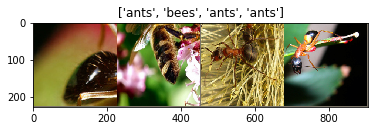

In [3]:
# 图片展示的函数
def imshow(inp, title=None):
    """Imshow for Tensor."""
    # 逆转操作，从 tensor 变回 numpy 数组需要转换通道位置
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    # 从归一化后变回原始图片
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# 获取一个 batch 的训练数据
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#### 训练模型

In [4]:
# 训练模型的函数
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 每个 epoch 都分为训练阶段和验证阶段
        for phase in ['train', 'val']:
            # 注意训练和验证阶段，需要分别对 model 的设置
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 清空参数的梯度
                optimizer.zero_grad()

                # 只有训练阶段才追踪历史
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 训练阶段才进行反向传播和参数的更新
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 记录 loss 和 准确率
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 载入最好的模型参数
    model.load_state_dict(best_model_wts)
    return model

#### 可视化模型的预测结果

In [5]:
# 可视化模型预测结果，即展示图片和模型对该图片的预测类别信息，默认展示 6 张图片
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### 微调网络

In [6]:
# 加载 resnet18 网络模型，并且设置加载预训练模型
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# 修改输出层的输出数量，本次采用的数据集类别为 2
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 对所有网络层参数进行更新
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 学习率策略，每 7 个 epochs 乘以 0.1
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [11:02<00:00, 70649.98it/s]


In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4890 Acc: 0.7254
val Loss: 0.2996 Acc: 0.8693

Epoch 1/24
----------
train Loss: 0.5479 Acc: 0.7787
val Loss: 0.2183 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.5187 Acc: 0.7746
val Loss: 0.3793 Acc: 0.8431

Epoch 3/24
----------
train Loss: 0.3566 Acc: 0.8525
val Loss: 0.3520 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.4935 Acc: 0.8279
val Loss: 0.3501 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.5117 Acc: 0.8238
val Loss: 1.0010 Acc: 0.6732

Epoch 6/24
----------
train Loss: 0.3508 Acc: 0.8770
val Loss: 0.4271 Acc: 0.8758

Epoch 7/24
----------
train Loss: 0.3568 Acc: 0.8361
val Loss: 0.3240 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.3009 Acc: 0.8730
val Loss: 0.2952 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.3111 Acc: 0.8648
val Loss: 0.2864 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.3429 Acc: 0.8320
val Loss: 0.2626 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.2619 Acc: 0.9139
val Loss: 0.2580 Acc: 0.9346

Ep

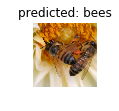

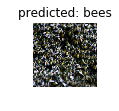

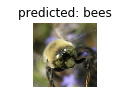

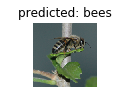

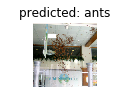

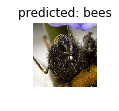

In [8]:
visualize_model(model_ft)

#### 用于特征提取器

In [9]:
model_conv = torchvision.models.resnet18(pretrained=True)
# 固定卷积层的权重参数
for param in model_conv.parameters():
    param.requires_grad = False

# 新的网络层的参数默认 requires_grad=True
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 只对输出层的参数进行更新
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 学习率策略，每 7 个 epochs 乘以 0.1
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [10]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6025 Acc: 0.6762
val Loss: 0.3528 Acc: 0.8366

Epoch 1/24
----------
train Loss: 0.4251 Acc: 0.7869
val Loss: 0.1762 Acc: 0.9542

Epoch 2/24
----------
train Loss: 0.4235 Acc: 0.8033
val Loss: 0.1706 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.4938 Acc: 0.7787
val Loss: 0.1930 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.3925 Acc: 0.8279
val Loss: 0.1950 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.4807 Acc: 0.7828
val Loss: 0.7189 Acc: 0.7778

Epoch 6/24
----------
train Loss: 0.5122 Acc: 0.8115
val Loss: 0.1818 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.4748 Acc: 0.8074
val Loss: 0.1547 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.4076 Acc: 0.8402
val Loss: 0.1746 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.2952 Acc: 0.8934
val Loss: 0.1600 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3626 Acc: 0.8607
val Loss: 0.1535 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3785 Acc: 0.8607
val Loss: 0.1526 Acc: 0.9542

Ep

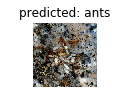

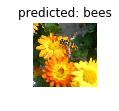

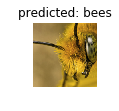

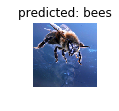

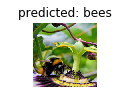

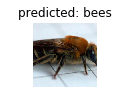

In [11]:
visualize_model(model_conv)

plt.ioff()
plt.show()